# Predicting breast cancer from digitized images of breast mass
by Rebecca Sokol-Snyder, William Song, and Chung Ki (Harry) Yau 2025/11/22

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.dummy import DummyClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

In [2]:
# read data
park = pd.read_csv("data/parks.csv", sep=";")
park

,ParkID,Name,Official,Advisories,SpecialFeatures,Facilities,Washrooms,StreetNumber,StreetName,EWStreet,NSStreet,NeighbourhoodName,NeighbourhoodURL,Hectare,GoogleMapDest
0,2,Carnarvon Park,1,N,N,Y,Y,2995,W 19th Avenue,W 19th Avenue,Mackenzie Street,Arbutus-Ridge,https://vancouver.ca/news-calendar/arbutus-rid...,3.79,"49.256555, -123.171406"
1,13,Coal Harbour Park,1,N,N,Y,N,480,Broughton Street,W Hastings Street,Broughton Street,Downtown,https://vancouver.ca/news-calendar/downtown.aspx,0.95,"49.289981, -123.125015"
2,16,David Lam Park,1,N,Y,Y,Y,1300,Pacific Boulevard,Drake Street,Pacific Boulevard,Downtown,https://vancouver.ca/news-calendar/downtown.aspx,4.34,"49.272569, -123.124145"
3,25,May & Lorne Brown Park,1,N,N,N,N,801,Beach Avenue,Beach Avenue,Hornby Street,Downtown,https://vancouver.ca/news-calendar/downtown.aspx,0.25,"49.275188, -123.132046"
4,26,Pioneer Place (Pigeon Park),1,N,N,N,N,399,Carrall Street,W Hastings Street,Carrall Street,Downtown,https://vancouver.ca/news-calendar/downtown.aspx,0.03,"49.281699, -123.104588"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
213,235,Granville Island Water Park,0,N,N,Y,N,1348,Cartwright Street,NaN,NaN,Fairview,https://vancouver.ca/news-calendar/fairview.aspx,0.00,"49.26955, -123.135064"
214,237,Yaletown Park,1,N,N,N,N,901,Mainland Street,Mainland Street,Nelson Street,Downtown,https://vancouver.ca/news-calendar/downtown.aspx,0.17,"49.277042, -123.118921"
215,238,Carolina Park,1,N,N,N,N,2100,Carolina Street,E 5th Avenue,Carolina Street,Mount Pleasant,https://vancouver.ca/news-calendar/mount-pleas...,0.08,"49.266401, -123.090778"
216,241,Habitat Island,0,N,N,N,N,1616,Columbia Street,NaN,NaN,Mount Pleasant,https://vancouver.ca/news-calendar/mount-pleas...,0.60,"49.27221, -123.110791"


In [3]:
# Summary of dataframe
park.describe()

,ParkID,Official,StreetNumber,Hectare
count,218.000000,218.000000,218.000000,218.000000
mean,119.908257,0.917431,2841.137615,6.200459
std,70.243689,0.275863,2128.224454,28.690242
min,1.000000,0.000000,50.000000,0.000000
25%,61.250000,1.000000,1177.250000,0.455000
50%,117.500000,1.000000,2390.000000,1.400000
75%,178.500000,1.000000,3930.750000,3.812500
max,249.000000,1.000000,9250.000000,400.000000


In [4]:
# listing features in dataframe
numeric_features = ['Hectare']
categorical_features = ['NeighbourhoodName']
binary_features = ['Official', 'Advisories', 'SpecialFeatures', 'Facilities']
drop_features = ['NeighbourhoodURL', 'ParkID', 'Name', 'GoogleMapDest', 'StreetNumber', 'StreetName', 'EWStreet', 'NSStreet']
target = "Washrooms"

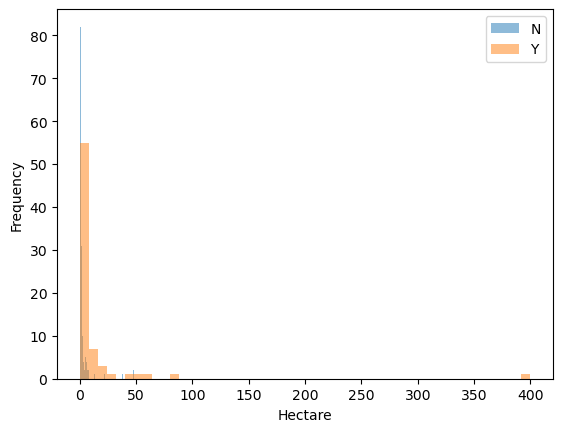

In [5]:
# Visualize numeric features
for col in numeric_features:
    park.groupby(target)[col].plot.hist(bins=50, alpha=0.5, legend=True)
    plt.xlabel(col);
    plt.show()

/var/folders/yv/k1d1hdvs4fzcqcjm0sx_qzm00000gn/T/ipykernel_62585/2532291025.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  binary_df['Official'] = binary_df['Official'].astype(str).replace({"1": "Y", "0": "N"})


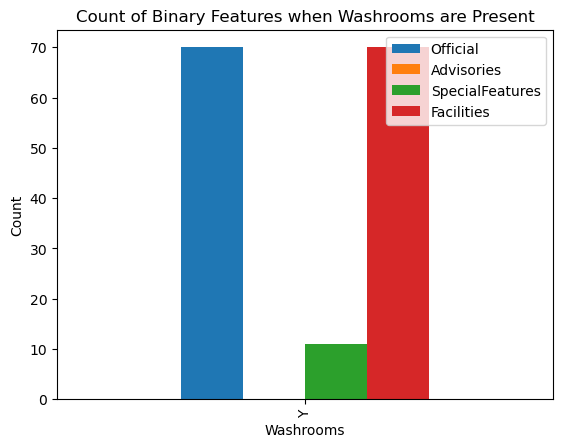

In [6]:
# Visualize binary features when there is washroom
binary_df = park[binary_features + [target]]
binary_df['Official'] = binary_df['Official'].astype(str).replace({"1": "Y", "0": "N"})
washroom_df = binary_df[binary_df[target] == "Y"]
washroom_df_count = washroom_df.groupby(target)[binary_features].apply(lambda group: (group == "Y").sum())
washroom_df_count
washroom_df_count.plot.bar()
plt.title("Count of Binary Features when Washrooms are Present")
plt.ylabel("Count")
plt.show()

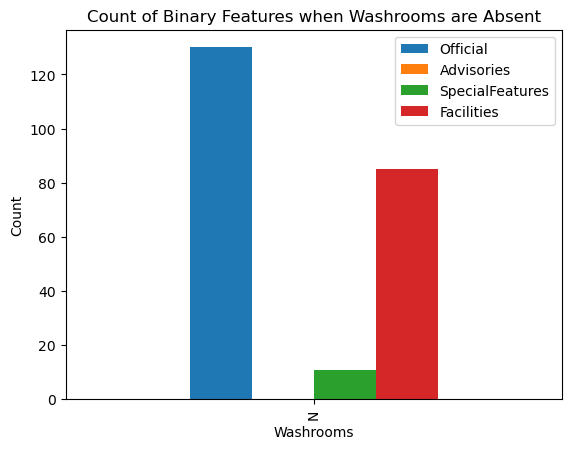

In [7]:
# Visualize binary features when there is no washroom
no_washroom_df = binary_df[binary_df[target] == "N"]
no_washroom_df_count = no_washroom_df.groupby(target)[binary_features].apply(lambda group: (group == "Y").sum())
no_washroom_df_count
no_washroom_df_count.plot.bar()
plt.title("Count of Binary Features when Washrooms are Absent")
plt.ylabel("Count")
plt.show()

In [8]:
# preprocessor for column transformation
categorical_transformer = make_pipeline(
    SimpleImputer(strategy="constant", fill_value="missing"), OneHotEncoder(handle_unknown="ignore", sparse_output=False)
)
preprocessor = make_column_transformer(
(StandardScaler(), numeric_features),
(OneHotEncoder(), binary_features),
(categorical_transformer, categorical_features),
("drop", drop_features)
)

In [9]:
# train and test data set up
train_df = train_test_split(park, test_size=0.6, random_state=123)[0]
test_df = train_test_split(park, test_size=0.6, random_state=123)[1]
X_train = train_df.drop(columns=[target])
y_train = train_df[target]
X_test = test_df.drop(columns=[target])
y_test = test_df[target]
y_test

204    Y
203    N
31     N
186    Y
169    N
      ..
199    N
179    N
200    Y
87     N
9      Y
Name: Washrooms, Length: 131, dtype: object

In [10]:
# Function for cv score, adapted from 571 lab 2
def mean_std_cross_val_scores(model, X_train, y_train, **kwargs):
    """
    Returns mean and std of cross validation
    Parameters
    ----------
    model :
    scikit-learn model
    X_train : numpy array or pandas DataFrame
    X in the training data
    y_train :
    y in the training data
    Returns
    ----------
    pandas Series with mean scores from cross_validation
    """
    scores = cross_validate(model, X_train, y_train, **kwargs)
    mean_scores = pd.DataFrame(scores).mean()
    std_scores = pd.DataFrame(scores).std()
    out_col = []
    for i in range(len(mean_scores)):
        out_col.append((f"%0.3f (+/- %0.3f)" % (mean_scores.iloc[i], std_scores.iloc[i])))
    return pd.Series(data=out_col, index=mean_scores.index)

In [11]:
# Setup model and pipline
model = DummyClassifier(random_state=123)
pipe = make_pipeline(preprocessor, model)

In [12]:
dummy_df = pd.DataFrame({
    "dummy" : mean_std_cross_val_scores(pipe, X_train, y_train, cv=5, return_train_score=True)
})
dummy_df.transpose()

,fit_time,score_time,test_score,train_score
dummy,0.003 (+/- 0.001),0.001 (+/- 0.000),0.748 (+/- 0.023),0.747 (+/- 0.006)


In [13]:
# RBF SVC model implementation
svm_rbf_classifier = SVC(kernel='rbf', C=1.0, gamma='scale') 
pipe2 = make_pipeline(preprocessor, svm_rbf_classifier)
svm_rbf_df = pd.DataFrame({
    "svm_rbf" : mean_std_cross_val_scores(pipe2, X_train, y_train, cv=5, return_train_score=True)
})
svm_rbf_df.transpose()

,fit_time,score_time,test_score,train_score
svm_rbf,0.003 (+/- 0.000),0.002 (+/- 0.000),0.771 (+/- 0.051),0.807 (+/- 0.022)


In [14]:
# knn model implementation
knn_classifier = KNeighborsClassifier(n_neighbors=5)
pipe3 = make_pipeline(preprocessor, knn_classifier)
knn_df = pd.DataFrame({
    "knn" : mean_std_cross_val_scores(pipe3, X_train, y_train, cv=5, return_train_score=True)
})
knn_df.transpose()

,fit_time,score_time,test_score,train_score
knn,0.002 (+/- 0.000),0.008 (+/- 0.014),0.746 (+/- 0.058),0.833 (+/- 0.019)


In [15]:
result = pd.merge(dummy_df, svm_rbf_df, left_index=True, right_index=True)
result = pd.merge(result, knn_df, left_index=True, right_index=True)
result

,dummy,svm_rbf,knn
fit_time,0.003 (+/- 0.001),0.003 (+/- 0.000),0.002 (+/- 0.000)
score_time,0.001 (+/- 0.000),0.002 (+/- 0.000),0.008 (+/- 0.014)
test_score,0.748 (+/- 0.023),0.771 (+/- 0.051),0.746 (+/- 0.058)
train_score,0.747 (+/- 0.006),0.807 (+/- 0.022),0.833 (+/- 0.019)


### Summary

We retrieved the public Park data from the City of Vancouver Open Data Portal. We aim to construct a classification model using the adequate algorithm to help us evaluate the factors that influenced the construction of washroom which is one of the important amenities in public parks. We used two models, KNN and SVM RBVF, to test our data. 

The cross-validation result shows that SVM RBF provides a small but consistent improvement over the baseline, while KNN overfits and fails to generalize. The dataset may require richer features or alternative models to achieve stronger predictive performance on washroom availability.

### Introduction

The Vancouver parks dataset offers a comprehensive view of the city’s green spaces, capturing details from park names and neighbourhoods to special features and facilities. The Washrooms column is particularly valuable, as it reveals which parks provide public washrooms and which do not. By linking this information to neighbourhoods and park sizes, the dataset becomes a powerful tool for assessing accessibility and identifying gaps in essential amenities across Vancouver’s park system.

By treating washroom presence as a target variable, we wonder if we can use machine learning algorithm to help us predict where facilities are most needed, identify underserved neighbourhoods, and optimize future installations. Using features such as park size, amenities, and neighbourhood context, ML models can uncover hidden patterns in service distribution and guide equitable infrastructure planning.